In [ ]:
# this notebook loads and cleans nora's original sheet 'ctx_sc_cases.csv'
# the resulting dataframe is written to ''ctx_sc_cases_clean.csv'

In [62]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from translate_colors import TranslateColors
%matplotlib inline

In [66]:
# read csv file and clean dataframe
df = pd.read_csv('ctx_sc_cases_06102020.csv', quotechar='\"', skipinitialspace=True, skiprows=4)
# strip space in column names
df.columns = df.columns.str.strip()
# remove all asterisk character
for column in df.columns:
    try:
        df[column] = df[column].str.replace('\*', '').str.strip()
    except AttributeError:
        pass  
# drop rows where case id is NA or does not match case ID pattern
# not enforcing case id ends with pattern due to such entries: SW121031-03B/A
df = df.loc[df['Case ID'].notna() & df['Case ID'].str.match('[A-Z]{2}[0-9]{6}-[0-9]{2}[A-D]')].reset_index()
# for actual injection site, split the secondary information.
# e.g. in VISp (med), med is secondary
df['Actual Anatomical/ Injection Site Secondary'] = \
    df['Actual Anatomical/ Injection Site'].str.split().str.get(1).str.replace('[()]', '')
df['Actual Anatomical/ Injection Site'] = df['Actual Anatomical/ Injection Site'].str.split().str.get(0)
# SSp_tr is semantically the same as SSp-tr
df.loc[df['Actual Anatomical/ Injection Site'] == 'SSp_tr', 'Actual Anatomical/ Injection Site'] = 'SSp-tr'
# split tracer and channel number
df_tracer_channel = df['Tracers/Channel'].str.split('/', expand=True)
df_tracer_channel.columns = ['Tracers', 'Channel']
# make tracer lower case. remove leading numbered list characters. replace aav-tdtom as aav-tdtomato
df_tracer_channel['Tracers'] = df_tracer_channel['Tracers'].str.strip().str.lower().str.replace('[0-9]\.[ ]*', '').str.replace('tdtom$', 'tdtomato')
# remove leading Ch in channel number
df_tracer_channel['Channel'] = df_tracer_channel['Channel'].str.strip().str.lower().str.replace('ch', '')
df = pd.concat([df, df_tracer_channel], axis=1).reset_index()
# retain only useful columns
relevant_columns = ['Case ID', 'Tracers', 'Channel', 'Cortex name with regional identifier', 'Actual Anatomical/ Injection Site', 
                    'Layer (injection site)', 'Injection Site center ARA level (c)', 'ML (X)', 'AP (Y)', 'DV (Z)', 'Nissl Quality', 
                    'Notes on SC labeling', 'Case path (vsi files)', 'Case Path (Thresholded Files)', 'Case path (osp files)', 
                    'Actual Anatomical/ Injection Site Secondary']
df = df[relevant_columns]
# modify file paths to linux system
for path_column in ['Case path (vsi files)', 'Case Path (Thresholded Files)', 'Case path (osp files)']:
    df[path_column] = df[path_column].str.replace('\\', '/').str.replace('Z:', '/ifs/loni/faculty/dong/mcp')    
# if both 'Case Path (Thresholded Files)', 'Case path (osp files)' are missing values, drop rows
df = df.loc[df['Case path (osp files)'].notna() | df['Case Path (Thresholded Files)'].notna(), :]
# if 'Case Path (Thresholded Files)' is missing, fill with 'Case path (osp files)'
df['Case Path (Thresholded Files)'] = df['Case Path (Thresholded Files)'].fillna((df['Case path (osp files)'] + '/threshold/channels/').str.cat(others=df['Channel']))
# if 'Case Path (osp files)' is missing, fill with 'Case path (Thresholded Files)'
df['Case path (osp files)'] = df['Case path (osp files)'].fillna(df['Case Path (Thresholded Files)'].str.replace('/threshold/channels/[0-5]', ''))

In [67]:
# check case id in index match case id in osp file path
case_ids = df['Case ID'].apply(lambda x: re.match('[A-Z]{2}[0-9]{6}-[0-9]{2}[A-D]', x).group(0))
osp_case_ids = df['Case path (osp files)'].str.split('/').str[-1].str.replace('SC_study_', '')
matches = case_ids == osp_case_ids
# remove inconsistent rows
if not matches.all():
    print('dropping \"Case ID\" inconsistent with \"Case path (osp files)\": {}'.format(df.loc[~matches.values, :]['Case ID'].values))
df = df.loc[matches, :]

In [68]:
# check threshold directory is valid combination of osp dir and channel number
expected_threshold_dirs = df['Case path (osp files)'] + '/threshold/channels/' + df['Channel']
matches = expected_threshold_dirs == df['Case Path (Thresholded Files)']
# remove inconsistent rows
if not matches.all():
    print('dropping \"Case ID\" with inconsistent \"Channel\" and \"Case Path (Thresholded Files)\": {}'.format(df.loc[~matches.values, :]['Case ID'].values))
df = df.loc[matches, :]    

In [69]:
# set case_id and channel multi index
df = df.set_index(['Case ID', 'Channel'])
# drop any duplicate multi index
df = df.loc[~df.index.duplicated(), :]
df.head() 

Tracers Cortex name with regional identifier  \
Case ID      Channel                                                      
SW121221-02A 2            phal-488                        VISp caudomed   
             4                 bda                        VISp caudolat   
SW121221-03A 2            phal-488                         VISp rostral   
             4                 bda                          VISp caudal   
SW151215-03A 3        aav-tdtomato                             PTLp lat   

                     Actual Anatomical/ Injection Site Layer (injection site)  \
Case ID      Channel                                                            
SW121221-02A 2                                    VISp                      5   
             4                                    VISp                      5   
SW121221-03A 2                                    VISp                      6   
             4                                    VISp                      5   
SW151215-03A 3                                    PTLp                      5   

                     Injection Site center ARA level (c)  ML (X)  AP (Y)  \
Case ID      Channel                                                       
SW121221-02A 2                                        96    2.50   -4.28   
             4                                        96    2.75   -4.28   
SW121221-03A 2                                        86    5.00   -3.28   
             4                                   94 (95)    1.80   -4.12   
SW151215-03A 3                                80, 82, 84    3.60   -2.88   

                      DV (Z) Nissl Quality Notes on SC labeling  \
Case ID      Channel                                              
SW121221-02A 2         -1.00           NaN                  NaN   
             4         -1.25           NaN                  NaN   
SW121221-03A 2         -1.75           NaN                  NaN   
             4         -0.75           NaN                  NaN   
SW151215-03A 3         -1.75           NaN                  NaN   

                                                  Case path (vsi files)  \
Case ID      Channel                                                      
SW121221-02A 2        /ifs/loni/faculty/dong/mcp/Scans/CTX/ORB AUD V...   
             4        /ifs/loni/faculty/dong/mcp/Scans/CTX/ORB AUD V...   
SW121221-03A 2        /ifs/loni/faculty/dong/mcp/Scans/CTX/ORB AUD V...   
             4        /ifs/loni/faculty/dong/mcp/Scans/CTX/ORB AUD V...   
SW151215-03A 3        /ifs/loni/faculty/dong/mcp/Scans/CP+CTX/SW1512...   

                                          Case Path (Thresholded Files)  \
Case ID      Channel                                                      
SW121221-02A 2        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
             4        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
SW121221-03A 2        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
             4        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
SW151215-03A 3        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   

                                                  Case path (osp files)  \
Case ID      Channel                                                      
SW121221-02A 2        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
             4        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
SW121221-03A 2        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
             4        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   
SW151215-03A 3        /ifs/loni/faculty/dong/mcp/Neda/ConnectionLens...   

                     Actual Anatomical/ Injection Site Secondary  
Case ID      Channel                                              
SW121221-02A 2                                               med  
             4                                            center  
SW121221-03A 2                                               med  
             4   

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100 entries, (SW121221-02A, 2) to (SW190619-04A, 4)
Data columns (total 14 columns):
Tracers                                        100 non-null object
Cortex name with regional identifier           86 non-null object
Actual Anatomical/ Injection Site              100 non-null object
Layer (injection site)                         93 non-null object
Injection Site center ARA level (c)            95 non-null object
ML (X)                                         86 non-null float64
AP (Y)                                         86 non-null float64
DV (Z)                                         86 non-null float64
Nissl Quality                                  5 non-null object
Notes on SC labeling                           28 non-null object
Case path (vsi files)                          92 non-null object
Case Path (Thresholded Files)                  100 non-null object
Case path (osp files)                          100 non-null object
A

In [71]:
print('total case number = {}'.format(df.shape[0]))
print('number of cases with known tracer = {}'.format(df.Tracers.count()))
print('number of cases with known injection site = {}'.format(df['Actual Anatomical/ Injection Site'].count()))

total case number = 100
number of cases with known tracer = 100
number of cases with known injection site = 100


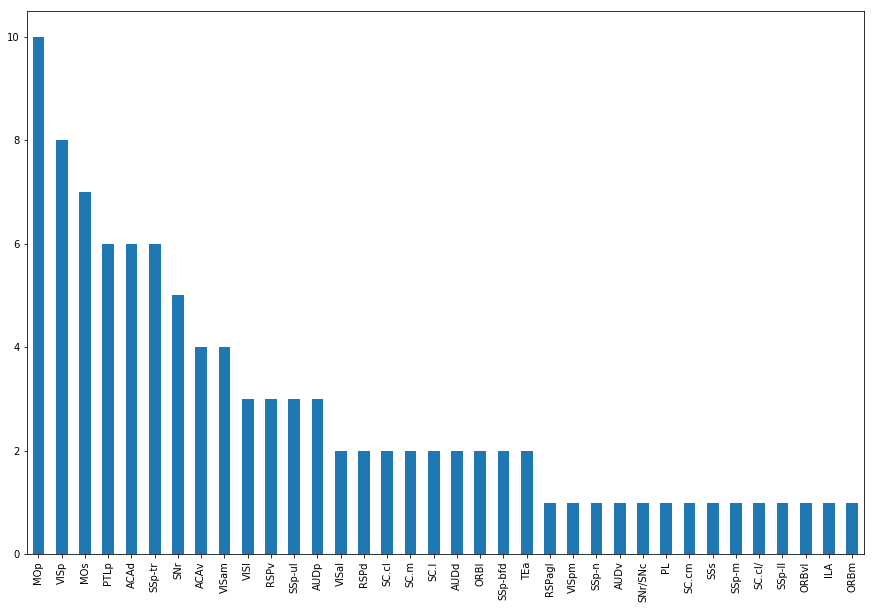

In [72]:
df['Actual Anatomical/ Injection Site'].value_counts().plot(kind='bar', figsize=(15, 10))

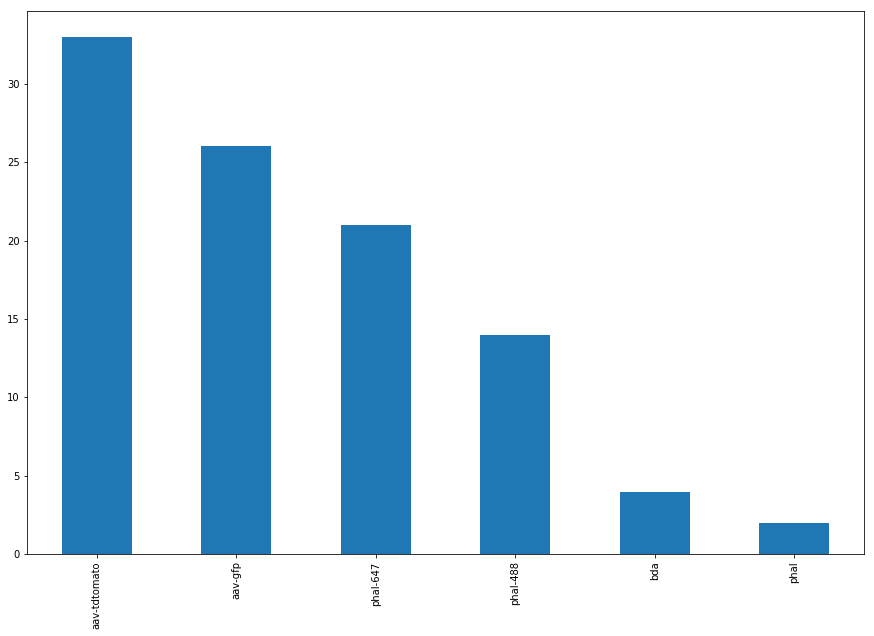

In [73]:
df['Tracers'].value_counts().plot(kind='bar', figsize=(15, 10))

In [74]:
df_injection_tracer = df.groupby('Actual Anatomical/ Injection Site')['Tracers'].value_counts().rename('counts').reset_index()
df_injection_tracer

,Actual Anatomical/ Injection Site,Tracers,counts
0,ACAd,aav-tdtomato,3
1,ACAd,phal-647,3
2,ACAv,phal-488,2
3,ACAv,aav-tdtomato,1
4,ACAv,phal-647,1
...,...,...,...
63,VISp,bda,2
64,VISp,phal-488,2
65,VISp,aav-tdtomato,1
66,VISp,phal-647,1


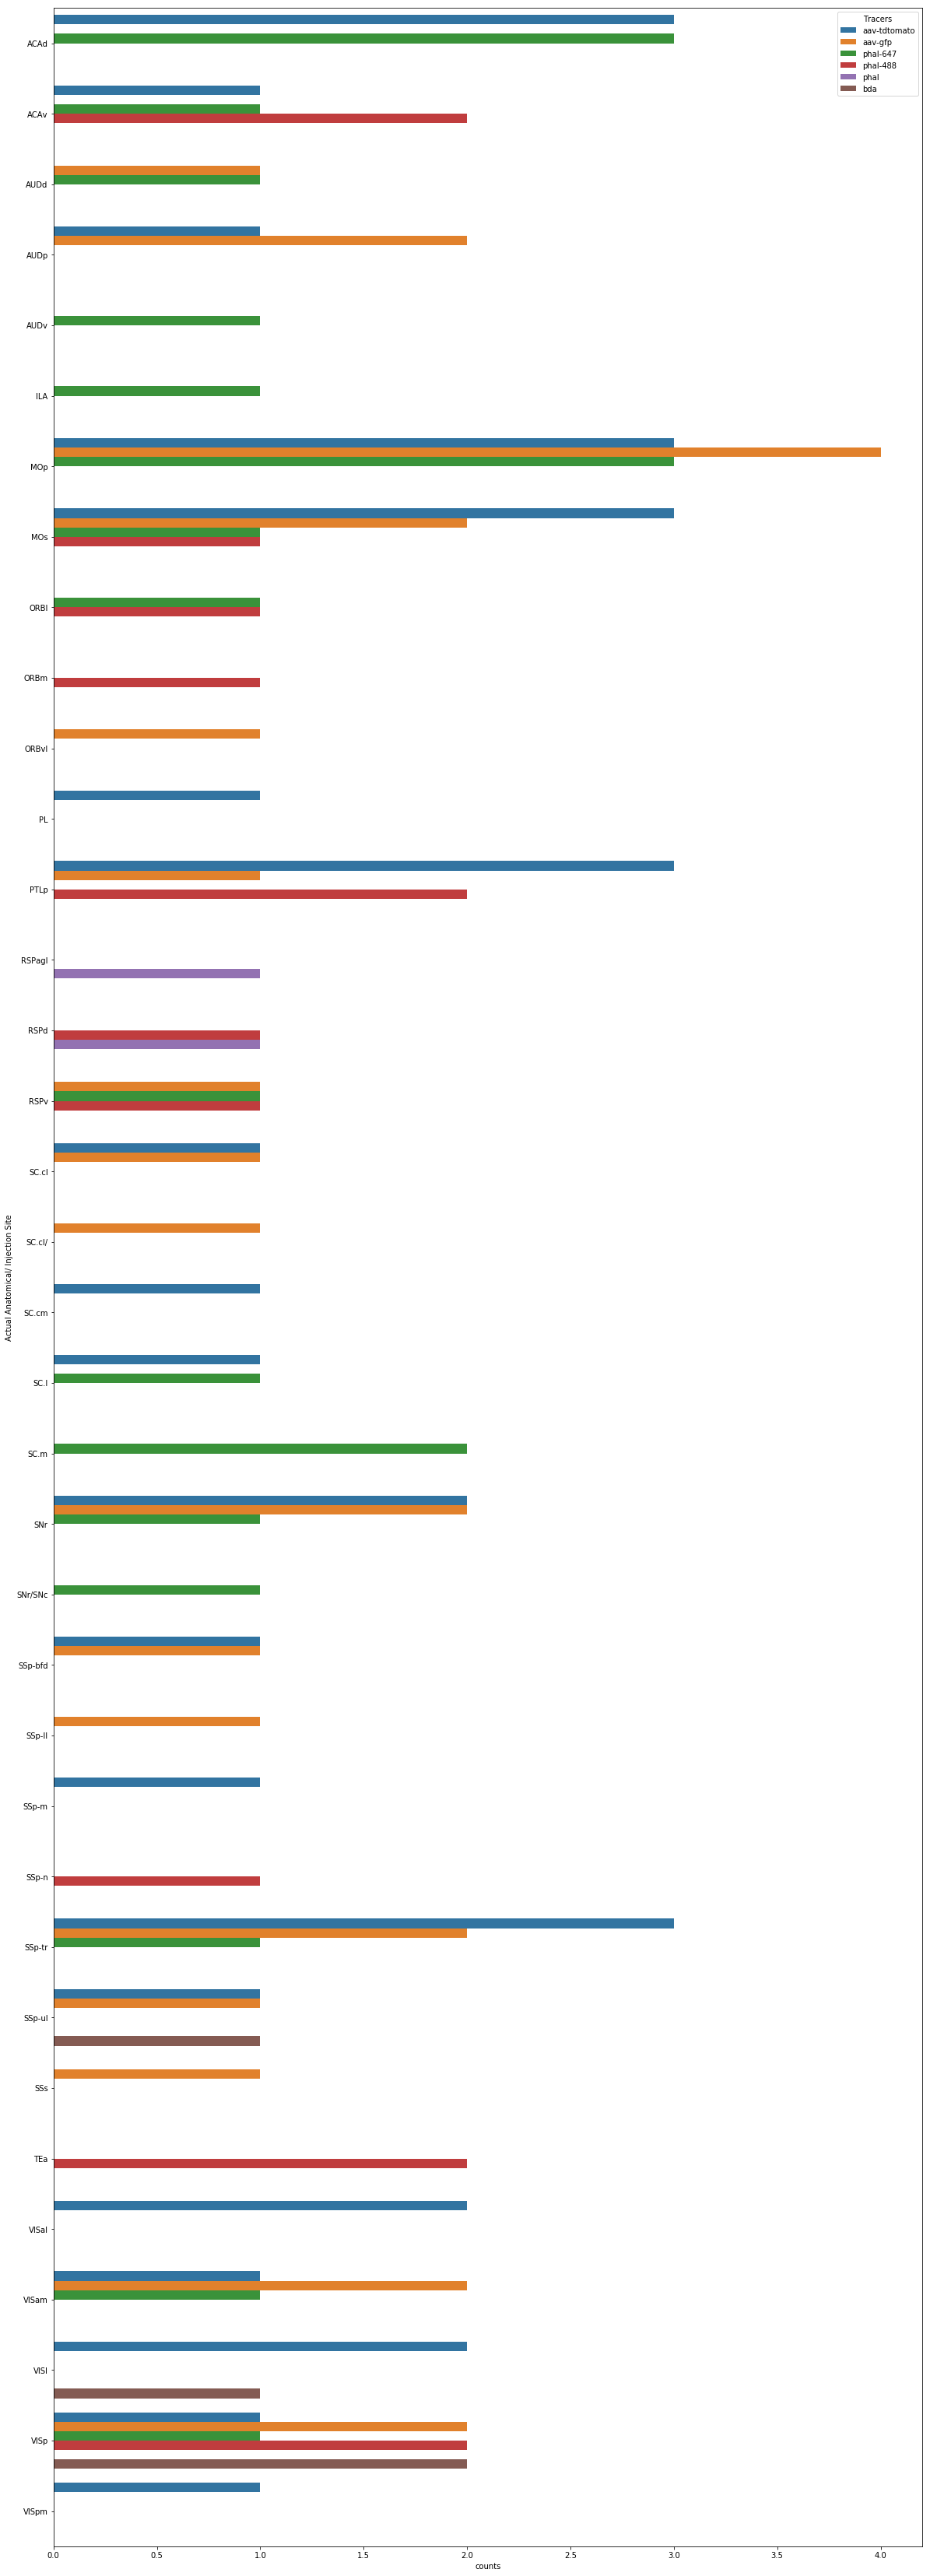

In [75]:
fig, ax = plt.subplots(figsize=(20, 60))
sns.barplot(y='Actual Anatomical/ Injection Site', x='counts', hue='Tracers', 
            hue_order=['aav-tdtomato', 'aav-gfp', 'phal-647', 'phal-488', 'phal', 'bda'], data=df_injection_tracer, ax=ax)

In [ ]:
# what does asterisk at end of case id mean: cases with both contralateral and ipsilateral labeling has an asterisk (Nora)
# ML, AP, DV columns: actual injection coordinate (Nora)
# diff between Cortex name with regional identifier and Actual Anatomical/ Injection Site
# foot note section: On iConnectome, OTHER, include?
# tally in foot note section: not same as above

In [76]:
# save cleaned dataframe
df.to_csv('ctx_sc_cases_clean.csv')